## Comparing sweights vs MLE

Compare sWeights and MLE on the same data.

In [1]:
#import essential packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

#defining the pdfs 
from scipy.stats import crystalball, norm

#for finding maximum of total pdf, curve fit
from scipy.optimize import minimize, curve_fit

#EML fit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

#sWeights package
from sweights import SWeight

#timing how long functions take
import timeit

#show the loading bar
from tqdm import tqdm

#plotting uncertainties
from uncertainties import ufloat

In [2]:
#define the functions using scipy stats 
#commented out scipy stats functions because they are slower
#defined equations instead

#signal for X
def g_s(X, beta, m, mu, sigma):
    return crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))

# def h_s(Y, lmbda):
#     trunc_b = (10.0 - 0.0)*lmbda
#     return truncexpon.pdf(Y, trunc_b, 0.0, 1/lmbda)


#signal for Y
def h_s(Y, lmbda):
    pdf = lmbda * np.exp(-lmbda * Y)
    norm_factor = 1 - np.exp(-10 * lmbda)
    return pdf / norm_factor

# def g_b(X):
#     return uniform.pdf(X, 0.0, 5.0)

#background for X
def g_b(X):
    if isinstance(X, (float, int)): #scalar input
        return 1/5.0 if 0 <= X <= 5 else 0
    else:  # numpy array input
        return np.where((X >= 0) & (X <= 5), 1/5.0, 0)

# def h_b(Y, mu_b, sigma_b):
#     a = (mu_b - 0.0)/sigma_b
#     b = (10.0 - mu_b)/sigma_b
#     return truncnorm.pdf(Y, a, b, mu_b, sigma_b)

#background for Y
def h_b(Y, mu_b, sigma_b):
    pdf = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    return pdf / norm_factor

#marginal distribution in X
def marg_X(X, f, mu, sigma, beta, m):
    return f*g_s(X, beta, m, mu, sigma) + (1-f)*g_b(X)

#marginal distribution in Y
def marg_Y(Y, f, lmbda, mu_b, sigma_b):
    return f*h_s (Y, lmbda) + (1-f)*h_b(Y, mu_b, sigma_b)

#total signal distribution
def signal(X, Y, mu, sigma, beta, m, f, lmbda):
    return f * g_s(X, beta, m, mu, sigma) * h_s(Y, lmbda)

#total background distribution 
def background(X, Y, f, mu_b, sigma_b):
    return (1-f) * g_b(X) * h_b(Y, mu_b, sigma_b)

#total joint distribution
def total(X, Y, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):
    return signal(X, Y, mu, sigma, beta, m, f, lmbda) + background(X, Y, f, mu_b, sigma_b)


In [3]:
#Create find max of this 2d function
def find_fmax_2d(func, x_range = (0.0, 5.0), y_range = (0.0, 10.0)):
    f_to_min = lambda vars: -func(vars[0], vars[1])
    initial_guess = [0,1]
    result = minimize(f_to_min, x0 = initial_guess, bounds = [x_range, y_range])
    max_x, max_y = result.x
    max_f = func(max_x, max_y)
    return max_f

#quicker accept reject sampler
def accept_reject_2d(func, x_range = [0, 5], y_range = [0, 10], num_samples=50, seed=1, batch_size=1000):

    np.random.seed(seed)
    
    x_samples = []
    y_samples = []

    f_max = find_fmax_2d(func)
    
    while len(x_samples) < num_samples:
        # Generate a batch of random samples
        x_temp = np.random.uniform(x_range[0], x_range[1], batch_size)
        y_temp = np.random.uniform(y_range[0], y_range[1], batch_size)
        f_temp = np.random.uniform(0, f_max, batch_size)
        
        # Evaluate the function for the batch
        f_values = func(x_temp, y_temp)
        
        # Apply the acceptance criterion
        accepted = f_temp < f_values
        
        # Append accepted samples
        x_samples.extend(x_temp[accepted])
        y_samples.extend(y_temp[accepted])
    
    # Convert lists to arrays and trim to the desired number of samples
    x_samples = np.array(x_samples[:num_samples])
    y_samples = np.array(y_samples[:num_samples])
    
    return x_samples, y_samples

In [51]:
#Parametric bootstrapping
#ensembles of 250 samples. Each sample has size 500, 1000, 2500, 5000, 10000

N_sample = [500, 1000, 2500, 5000, 10000] #number of samples per toy
param_names = ['N', '\mu', '\sigma', '\\beta', 'm', 'f', '\lambda', '\mu_b', '\sigma_b']
true_values = [3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5]#except N which differs
fitted_values = np.loadtxt('data_storage/fitted_values.csv', delimiter=',')
fitted_values = fitted_values[1:] #get rid of the N value because we will change this for each bootstrap

#create new joint distribution with fitted parameters instead
def total_fixed_fitted(X, Y):
    return total(
        X, Y, 
        mu=fitted_values[0], sigma=fitted_values[1], beta=fitted_values[2], m=fitted_values[3], 
        f=fitted_values[4], lmbda=fitted_values[5], mu_b=fitted_values[6], sigma_b=fitted_values[7]
    )

def model_density(data, N, mu, sigma, beta, m, f, lmbda, mu_b, sigma_b):

    X, Y = data

    g_s = crystalball.pdf(X, beta, m, mu, sigma) / max((crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma)), 1e-10)

    pdf = lmbda * np.exp(-lmbda * Y)
    norm_factor = 1 - np.exp(-10 * lmbda)
    h_s = pdf/norm_factor

    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    pdf0 = (1/(sigma_b * np.sqrt(2*np.pi))) * np.exp(-(Y - mu_b)**2 / (2*sigma_b**2))
    norm_factor0 = norm.cdf(10, mu_b, sigma_b) - norm.cdf(0, mu_b, sigma_b)
    h_b = pdf0/norm_factor0

    signal = f * g_s * h_s
    background = (1-f) * g_b * h_b

    total = signal + background

    return N, N*total

#Make a bootstrap of size N
def generate_bootstrap (N, seed = 1):
    N = np.random.poisson(N)
    x_samples, y_samples = accept_reject_2d(total_fixed_fitted, num_samples=N, seed = seed)
    
    return x_samples, y_samples

#make an ensemble of these bootstrapped value 
def generate_ensemble(N_sample, N_ensemble = 250):
    toys = [generate_bootstrap(N_sample, seed= i) for i in tqdm(range(N_ensemble))]
    return toys 

#fit a sample using the fitted values 
def fit_model(data, N_sample):
    X, Y = data
    nll = ExtendedUnbinnedNLL((X,Y), model_density)
    #starting params
    mi = Minuit(nll, 
            N=N_sample,
            mu=fitted_values[0], 
            sigma=fitted_values[1], 
            beta=fitted_values[2], 
            m=fitted_values[3], 
            f=fitted_values[4], 
            lmbda=fitted_values[5], 
            mu_b=fitted_values[6], 
            sigma_b=fitted_values[7])
    #limits
    mi.limits["N"] = (0, None)
    mi.limits["beta"] = (0, 10)
    mi.limits["m"] = (1, 10)
    mi.limits['sigma'] = (0,None)
    mi.limits['sigma_b'] = (0, None)

    mi.migrad()
    mi.hesse()

    return mi

In [ ]:
#sweights code

#New model density for X
def X_model_density(X, Ns, Nb, mu, sigma, beta, m):

    #define pdfs again here, because it is quicker for the minimiser
    g_s = crystalball.pdf(X, beta, m, mu, sigma) / max((crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma)), 1e-10) #just in case it gets so small

    #g_b = uniform.pdf(X, 0.0, 5.0)
    g_b = np.where((X >= 0) & (X <= 5), 1/5.0, 0)

    signal = Ns * g_s
    background = Nb * g_b

    total = signal + background

    return Ns+Nb, total

def fit_X_model_density (data, N_sample):

    X, Y = data
    #fit the X data
    nll = ExtendedUnbinnedNLL(X, X_model_density)

    mi = Minuit(nll, 
                Ns = N_sample * fitted_values[4],
                Nb = N_sample * (1-fitted_values[4]),
                mu=fitted_values[0],
                sigma=fitted_values[1],
                beta=fitted_values[2],
                m=fitted_values[3]
)

    #input limits
    mi.limits["Ns"] = (0, None)
    mi.limits["Nb"] = (0, None)
    mi.limits["beta"] = (0, 10)
    mi.limits["m"] = (1, 10)
    mi.limits["sigma"] = (0, 10)

    mi.migrad()
    mi.hesse()

    return mi

def get_sweights (data, mi):
    
    X, Y = data
    #define pdfs to put into sWeights
    spdf = lambda x: g_s(x, mi.values['beta'], mi.values['m'], mi.values['mu'], mi.values['sigma'])
    bpdf = lambda x: g_b(x)
    sweight = SWeight(X, [spdf, bpdf], yields = [mi.values['Ns'], mi.values['Nb']], discvarranges=([0,5],), verbose = False, checks = False)
    
    sw = sweight.get_weight(0, X)
    #bw = sweight.get_weight(1, X)
    ysw, ye = np.histogram(Y, bins = 50, range = [0,10], weights = sw, density = True)
    cy = 0.5 * (ye[1:] + ye[:-1]) 

    popt, _ = curve_fit(lambda y, lmbda: h_s(y, lmbda), cy, ysw, fitted_values[5])
    lmbda_sw = popt[0]

    return lmbda_sw

In [ ]:
def bootstrap(N_sample, N_ensemble = 250):
    #generate toys 
    toys = generate_ensemble(N_sample, N_ensemble= N_ensemble)
    print('Finished generating samples')
    values = []
    errors = []
    invalid_fits = 0
    invalid_fits_sw = 0
    lmbdas_sw = []
    print('Fitting samples.')

    #fit all of the toys
    for toy in tqdm(toys):
        #MLE fit of params
        mi = fit_model(toy, N_sample)
        if mi.valid:
            values.append(list(mi.values))
            errors.append(list(mi.errors))
        else:
            invalid_fits += 1
        #sweight fit of lmbda 
        mi_X = fit_X_model_density(toy, N_sample)
        if mi_X.valid:
            lmbda_sw = get_sweights(toy, mi_X)
            lmbdas_sw.append(lmbda_sw)
        else:
            invalid_fits_sw += 1
        
        #print(len(mi.values))

    #get the values, errors and pulls
    values = np.array(values)
    #print(len(values[0]))
    errors = np.array(errors)
    #print(errors)
    fitted_values_t = np.concatenate((np.array([N_sample]), fitted_values))
    #print(len(fitted_values_t))
    pulls = (values - fitted_values_t)/errors

    #save MLE fits
    np.savetxt(f'data_storage/bootstraps/bootstrap_{N_sample}.csv', 
           np.column_stack((values, errors, pulls)), 
           delimiter=',',
           header='values, errors, pulls')
    
    np.savetxt(f'data_storage/bootstraps_sweights/bootstrap_{N_sample}.csv', 
               lmbdas_sw, delimiter= ',', header = 'estimated lmbda')
    
    print(f'Invalid fits for MLE are {invalid_fits} out of {N_ensemble} toys')
    print(f'Invalid fits for sWeights are {invalid_fits_sw} out of {N_ensemble} toys')

    return None

In [65]:
N_samples = [500, 1000, 2500, 5000, 10000]
for N_sample in N_samples:
    bootstrap(N_sample, 500)

100%|██████████| 500/500 [00:12<00:00, 39.97it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [07:32<00:00,  1.10it/s]


Invalid fits for MLE are 15 out of 500 samples
Invalid fits for sWeights are 1 out of 500 samples


100%|██████████| 500/500 [00:15<00:00, 33.09it/s]


Finished generating samples
Fitting samples.


 18%|█▊        | 90/500 [01:14<10:25,  1.53s/it]C:\Users\eliza\AppData\Local\Temp\ipykernel_31860\1110388164.py:7: RuntimeWarning: divide by zero encountered in divide
  g_s = crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))
100%|██████████| 500/500 [11:56<00:00,  1.43s/it]


Invalid fits for MLE are 22 out of 1000 samples
Invalid fits for sWeights are 1 out of 1000 samples


100%|██████████| 500/500 [00:47<00:00, 10.44it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [07:49<00:00,  1.06it/s]


Invalid fits for MLE are 14 out of 2500 samples
Invalid fits for sWeights are 0 out of 2500 samples


100%|██████████| 500/500 [01:33<00:00,  5.37it/s]


Finished generating samples
Fitting samples.


 85%|████████▌ | 426/500 [10:36<01:18,  1.05s/it]C:\Users\eliza\AppData\Local\Temp\ipykernel_31860\1110388164.py:7: RuntimeWarning: invalid value encountered in divide
  g_s = crystalball.pdf(X, beta, m, mu, sigma) / (crystalball.cdf(5.0, beta, m, mu, sigma) - crystalball.cdf(0.0, beta, m, mu, sigma))
100%|██████████| 500/500 [11:57<00:00,  1.43s/it]


Invalid fits for MLE are 12 out of 5000 samples
Invalid fits for sWeights are 2 out of 5000 samples


100%|██████████| 500/500 [01:00<00:00,  8.29it/s]


Finished generating samples
Fitting samples.


100%|██████████| 500/500 [13:21<00:00,  1.60s/it]

Invalid fits for MLE are 9 out of 10000 samples
Invalid fits for sWeights are 0 out of 10000 samples


In [85]:
lmbdas_sw_500 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_500.csv')
lmbdas_sw_1000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_1000.csv')
lmbdas_sw_2500 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_2500.csv')
lmbdas_sw_5000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_5000.csv')
lmbdas_sw_10000 = np.loadtxt('data_storage/bootstraps_sweights/bootstrap_10000.csv')

data_list_sw = [lmbdas_sw_500, lmbdas_sw_1000, lmbdas_sw_2500, lmbdas_sw_5000, lmbdas_sw_10000]
data_list_sw = [lmbda[:450] for lmbda in data_list_sw] #cut to all the same length

In [86]:
def get_lmbdas_mean_sw(data_list):
    lmbdas_mean = []
    lmbdas_std = []
    for lmbdas in data_list:
        lmbdas_mean.append(np.mean(lmbdas))
        lmbdas_std.append(np.std(lmbdas, ddof = 1)/np.sqrt(len(lmbdas)))
    return lmbdas_mean, lmbdas_std
lmbdas_mean_sw, lmbdas_std_sw = np.array(get_lmbdas_mean_sw(data_list_sw))
lmbdas_bias_sw = lmbdas_mean_sw - fitted_values[5]

N_samples

[500, 1000, 2500, 5000, 10000]

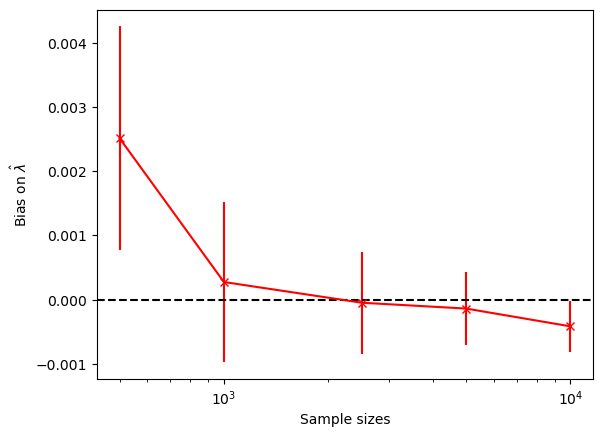

In [93]:
plt.errorbar(N_samples, lmbdas_bias_sw, yerr = lmbdas_std_sw, fmt = 'rx', ls = '-')
#plt.plot(N_samples, lmbdas_bias_sw, 'o', ls = '-')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'Bias on $\hat{\lambda}$')
plt.xlabel('Sample sizes')
plt.axhline(y=0, color = 'black', ls = '--')

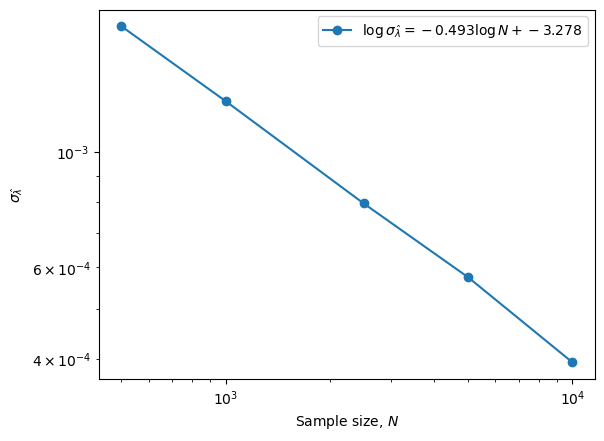

In [92]:
#Log-log plot should show linear line

log_var = np.log(lmbdas_std_sw)
log_N = np.log(N_samples)
coeffs = np.polyfit(log_N, log_var, 1)

plt.plot(N_samples, lmbdas_std_sw, 'o',ls = '-', 
         label = rf'$\log{{\sigma_{{\hat{{\lambda}}}}}} = {coeffs[0]:.3f}\log{{N}} + {coeffs[1]:.3f}$')
#plt.errorbar(N_sample, lmbdas_var, yerr = lmbdas_var_std) error bars so small you cannot see them
#plt.text(9, 0.31,r'$V(\hat{\lambda}) = $' + f'{coeffs[0]:.3f}' + r'$N$' + f'{coeffs[1]:.3f}', horizontalalignment='center',verticalalignment='center')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Sample size, $N$')
plt.ylabel(fr'$\sigma_{{\hat{{\lambda}}}}$')
plt.legend()